In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

MobileNet : https://medium.com/analytics-vidhya/image-classification-with-mobilenet-cc6fbb2cd470
The face mask detector didn't use any morphed masked images dataset. The model is accurate, and since the MobileNetV2 architecture is used, it’s also computationally efficient and thus making it easier to deploy the model to embedded systems (Raspberry Pi, Google Coral, etc.).

In [2]:
#initial lerning rate, epoches, Batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

In [3]:
DIRECTORY = r"C:\Users\k6023\Desktop\Hasitha\Project-20230219T130802Z-001\Project\dataset"
CATEGORIES = ["with_mask","without_mask"]

In [4]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY,category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)


In [5]:
#converl labels(withmask, withoutmask) into categorical variables /one to one encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [6]:
#convert data and labels into numpy arrays (because deep learnig models will work with numpy arrays)
data = np.array(data, dtype="float32")
labels = np.array(labels)

stratifed => stratify = y
https://www.youtube.com/watch?v=Zcjl8xPLmPw&ab_channel=DataSchool

In [7]:
#split training and testing data
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

https://keras.io/api/preprocessing/image/#imagedatagenerator-class

In [8]:
#construct the training image generator for data argumentation (create many image by single image)
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [9]:
#pretrained model , download mobilenet model
# mobilenet = cnn architecture, (v1 is slow)
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))


In [10]:
#extract features
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

All : Convolutional Neural Network : https://www.simplilearn.com/tutorials/deep-learning-tutorial/convolutional-neural-network#:~:text=Flattening%20is%20used%20to%20convert,layer%20to%20classify%20the%20image.

What is pooling https://programmathically.com/what-is-pooling-in-a-convolutional-neural-network-cnn-pooling-layers-explained/#:~:text=Pooling%20in%20convolutional%20neural%20networks,their%20location%20in%20the%20image.


In [12]:
# create head model object => then pass the base model output
headModel = baseModel.output
#create pooling, pool size =7x7
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
#flaten these layers
headModel = Flatten(name="flatten")(headModel)
# add dense layer with 128 neurons, activation function =relu
headModel = Dense(128, activation="relu")(headModel)
# Dropout just to avoid  overfitting our models
headModel = Dropout(0.5)(headModel)
#final output layer with 2 layers(withmask/withoutmask)
headModel = Dense(2, activation="softmax")(headModel)


In [13]:
#call model function
#model function accepst 2 parameters(input/output)
#input = basemodel.input, output = headmodel

model = Model(inputs=baseModel.input, outputs=headModel)


In [14]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [15]:
# compile our model
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

Batch Size and EPOCHS https://deeplizard.com/learn/video/U4WB9p6ODjM#:~:text=Put%20simply%2C%20the%20batch%20size,to%20the%20network%20at%20once.

In [16]:
# train the head of the network
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


Epoch 1/10
17/17 [==============================] - 23s 1s/step - loss: 0.7834 - accuracy: 0.5917 - val_loss: 0.2713 - val_accuracy: 0.9858
Epoch 2/10
17/17 [==============================] - 17s 1s/step - loss: 0.1851 - accuracy: 0.9811 - val_loss: 0.1018 - val_accuracy: 0.9858
Epoch 3/10
17/17 [==============================] - 17s 1s/step - loss: 0.1089 - accuracy: 0.9849 - val_loss: 0.0770 - val_accuracy: 0.9858
Epoch 4/10
17/17 [==============================] - 18s 1s/step - loss: 0.1007 - accuracy: 0.9835 - val_loss: 0.0693 - val_accuracy: 0.9858
Epoch 5/10
17/17 [==============================] - 17s 1s/step - loss: 0.1040 - accuracy: 0.9811 - val_loss: 0.0642 - val_accuracy: 0.9858
Epoch 6/10
17/17 [==============================] - 18s 1s/step - loss: 0.1041 - accuracy: 0.9811 - val_loss: 0.0594 - val_accuracy: 0.9858
Epoch 7/10
17/17 [==============================] - 18s 1s/step - loss: 0.1034 - accuracy: 0.9811 - val_loss: 0.0551 - val_accuracy: 0.9858
Epoch 8/10
17/17 [==

Validation Set vs. Test Set: https://www.statology.org/validation-set-vs-test-set/

In [17]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)


5/5 [==============================] - 4s 627ms/step


In [18]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)


In [19]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))



              precision    recall  f1-score   support

   with_mask       0.00      0.00      0.00         2
without_mask       0.99      1.00      0.99       139

    accuracy                           0.99       141
   macro avg       0.49      0.50      0.50       141
weighted avg       0.97      0.99      0.98       141



c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# serialize the model to disk
model.save("mask_detector_new2.model", save_format="h5")


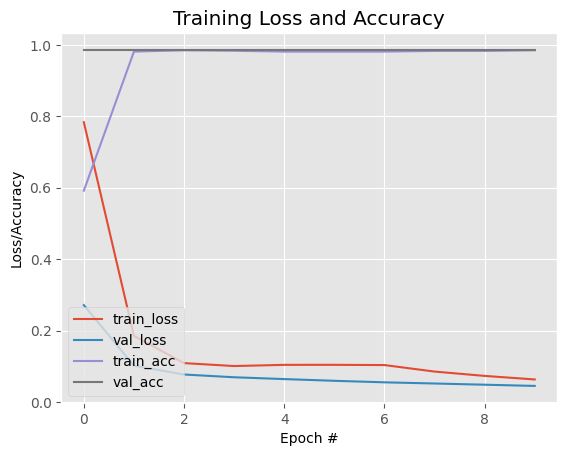

In [21]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot_new1.png")
